In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.notebook import tqdm as tqdm
import pdb
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
from IPython.display import clear_output

path_to_data = '../Inputs-Targets.csv'

In [3]:
class WeatherDataset(Dataset):
    def __init__(self, csv_file, train=True):
        # Make 80/20 test training split without preserving order
        self.data = pd.read_csv(csv_file)
        # If the model is trained in multiple sessions,
        # test and training data will not be consistent
        # self.data = self.data.sample(frac=1).reset_index(drop=True)
        self.train = self.data.iloc[:int(len(self.data)*0.8)]
        self.test = self.data.iloc[int(len(self.data)*0.8):]
        if train:
            self.data = self.train 
        else:   
            self.data = self.test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        # Return row as tensor
        x = torch.tensor(self.data.iloc[i][1:69])
        y = torch.tensor(self.data.iloc[i][69:72]).to(torch.float64)
        return x, y
        # return torch.tensor(self.data.iloc[i])

In [4]:
# Test dataset class

t_data = WeatherDataset(path_to_data)
t_dataloader = DataLoader(t_data, batch_size=4, shuffle=True)
print(len(t_dataloader.dataset))
for batch in t_dataloader:
    x, y = batch
    print(x.shape)
    print(y.shape)
    break

v_data = WeatherDataset(path_to_data, train=False)
v_dataloader = DataLoader(v_data, batch_size=4, shuffle=True)
print(len(v_dataloader.dataset))
for batch in t_dataloader:
    x, y = batch
    print(x.shape)
    print(y.shape)
    break

43635
torch.Size([4, 68])
torch.Size([4, 3])
10909
torch.Size([4, 68])
torch.Size([4, 3])


In [5]:
resnet = models.resnet50(pretrained=True)

# Define trivial model
class WeatherModel(nn.Module):
    def __init__(self):
        super(WeatherModel, self).__init__()
        self.fc1 = nn.Linear(68, 256, dtype=torch.float64)
        self.fc2 = nn.Linear(256, 256, dtype=torch.float64)
        self.fc3 = nn.Linear(256, 256, dtype=torch.float64)
        self.fc4 = nn.Linear(512, 256, dtype=torch.float64)
        self.fcf = nn.Linear(256, 3, dtype=torch.float64)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x_prime = torch.relu(self.fc2(x))
        x = torch.relu(torch.cat([self.fc3(x_prime), x_prime], dim=1))
        x = torch.relu(self.fc4(x))
        return self.fcf(x)

# Define resnet model
class Res50Model(nn.Module):
    def __init__(self):
        super(Res50Model, self).__init__()
        self.input_layer = nn.Linear(68, 224 * 224 * 3, dtype=torch.float64)
        self.resnet = resnet.double()
        self.output_layer = nn.Linear(1000, 3, dtype=torch.float64)

    def forward(self, x):
        x = self.input_layer(x)
        x = x.view(-1, 3, 224, 224)
        x = self.resnet(x)
        x = self.output_layer(x)
        return x

/Users/matthewgabbitas/opt/anaconda3/envs/cs474/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/Users/matthewgabbitas/opt/anaconda3/envs/cs474/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
BATCH_SIZE = 4
UPDATE_STATUS_EVERY = 200

# Make train and test datasets
train_data = WeatherDataset(path_to_data, train=True)
test_data = WeatherDataset(path_to_data, train=False)
# Initialize dataloaders
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [7]:
def cache_session(model, path='model.pt', stat_dict={}):
    torch.save(model.state_dict(), path)
    torch.save(stat_dict, 'stat_dict.pt')


def restore_session(model, model_path='model.pt', stat_dict_path='stat_dict.pt'):
   # Restore model and stats from cache if available, else initialize new model and stats
    try:
        model.load_state_dict(torch.load(model_path))
        stat_dict = torch.load(stat_dict_path)
        losses = stat_dict['losses']
        window_losses = stat_dict['window_losses']
        val_losses = stat_dict['val_losses']
        epoch_num = stat_dict['epoch_num']
        print('Restored session from cache at epoch {}'.format(epoch_num))
    except:
        losses = []
        window_losses = []
        val_losses = []
        epoch_num = 0
        print('Unable to restore. Initialized new model and new session')
    return model, epoch_num, losses, window_losses, val_losses

def plot_loss(losses, loss_indices):
  for i, l in enumerate(losses):
    loss_label = l[0]
    loss_x = loss_indices[i]
    loss_y = l[1]
    plt.plot(loss_x, loss_y, label=loss_label)
  plt.legend()
  plt.ylabel('Loss')
  plt.xlabel('Batches')
  plt.show()

  9%|9         | 9/100 [00:00<?, ?it/s]

  0%|          | 0/10909 [00:00<?, ?it/s]

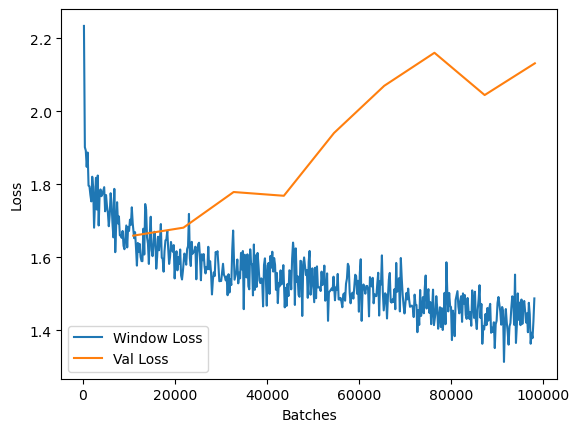

KeyboardInterrupt: 

In [9]:
# Train model
def train(epochs, model, epoch_num=0, losses_tuple=([], []), window_losses_tuple=([], []), val_losses_tuple=([], [])):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    total_batch_index = 0
    
    loss_indices = losses_tuple[0]
    losses = losses_tuple[1]
    window_loss_indices = window_losses_tuple[0]
    window_losses = window_losses_tuple[1]
    val_loss_indices = val_losses_tuple[0]
    val_losses = val_losses_tuple[1]

    # epochs_bar = tqdm(range(epochs), leave=False, position=epoch_num)

    for epoch in range(epoch_num, epochs):
        
        # Reset output for current epoch
        clear_output(wait=True)
        epochs_bar = tqdm(range(epochs), leave=False, initial=epoch) # Reset epochs bar
        try:
            epochs_bar.set_description(f'Epoch {epoch + 1}, Train Loss: {f"{recent_avg_loss:.3f}"}, Val Loss: {f"{avg_val_batch_loss:.3f}"}')
        except:
            epochs_bar.set_description(f'Epoch {epoch_num + 1}, Train Loss: N/A, Val Loss: N/A')

        batches_bar = tqdm(train_dataloader, leave=False)
        plot_loss(losses=(('Window Loss', window_losses), ('Val Loss', val_losses)),
                   loss_indices=(window_loss_indices, val_loss_indices)) # Plot current losses

        for batch in train_dataloader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_indices.append(total_batch_index)
            losses.append(loss.item())
            batches_bar.update()
            total_batch_index += 1

            # Update batch bar periodically during batch
            if batches_bar.n % UPDATE_STATUS_EVERY == 0:
                recent_avg_loss = sum(losses[-UPDATE_STATUS_EVERY:])/UPDATE_STATUS_EVERY
                window_loss_indices.append(total_batch_index)
                window_losses.append(recent_avg_loss)
                batches_bar.set_description(f'Epoch {epoch + 1}, Train Loss: {f"{recent_avg_loss:.3f}"}')

        # Validate every epoch
        val_batches_bar = tqdm(test_dataloader, leave=False)
        val_batches_bar.set_description(f'Validating...')
        val_batches_bar.update()
        val_batch_losses = []
        model.eval()
        for batch in test_dataloader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_batch_losses.append(loss.item())
            val_batches_bar.update()
        avg_val_batch_loss = sum(val_batch_losses)/len(val_batch_losses)
        val_loss_indices.append(total_batch_index)
        val_losses.append(avg_val_batch_loss)
        model.train()

        # Save model and losses
        stat_dict = {'epoch_num': epoch + 1,'losses': (loss_indices, losses), 'window_losses': (window_loss_indices, window_losses), 'val_losses': (val_loss_indices, val_losses)}
        cache_session(model ,stat_dict=stat_dict)

        # Update epoch bar
        epochs_bar.update()

model = WeatherModel()
# model = Res50Model()
EPOCHS = 100
do_restore = False
if do_restore:
    train(EPOCHS, *restore_session(model))
else:
    print('Initialized new model and new session')
    train(EPOCHS, model)

In [42]:
def validate_model(model, epoch_num=0, losses_tuple=([], []), window_losses_tuple=([], []), val_losses_tuple=([], [])):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.MSELoss()
    val_batches_bar = tqdm(test_dataloader, leave=False)
    val_batches_bar.set_description(f'Validating...')
    val_batches_bar.update()
    val_batch_losses = []
    corrects = 0
    val_loader_data_count = len(test_dataloader.dataset)*test_dataloader.batch_size
    model.eval()
    for batch in test_dataloader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)

        # Calculate loss
        loss = criterion(y_pred, y)

        # Calculate accuracy
        descrete_pred = torch.round(y_pred).clamp(1, 5)
        correct = torch.sum(descrete_pred == y)
        corrects += correct.item()

        val_batch_losses.append(loss.item())
        val_batches_bar.update()
    val_batches_bar.update()
    avg_val_batch_loss = sum(val_batch_losses)/len(val_batch_losses)
    avg_accuracy = corrects/val_loader_data_count
    model.train()

    loss_indices = losses_tuple[0]
    losses = losses_tuple[1]
    window_loss_indices = window_losses_tuple[0]
    window_losses = window_losses_tuple[1]
    val_loss_indices = val_losses_tuple[0]
    val_losses = val_losses_tuple[1]
    plot_loss(losses=(('Window Loss', window_losses), ('Val Loss', val_losses)),
                   loss_indices=(window_loss_indices, val_loss_indices))
    
    print(f'Val Loss: {f"{avg_val_batch_loss:.4}"}')
    print(f'Accuracy: {f"{avg_accuracy:.4}"}')

Restored session from cache at epoch 85


  0%|          | 0/2728 [00:00<?, ?it/s]

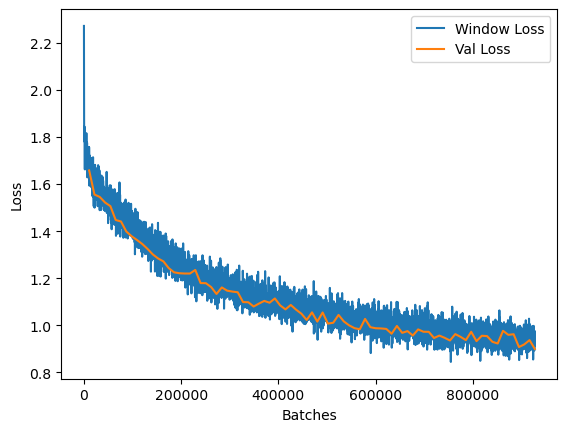

Val Loss: 0.9073
Accuracy: 0.3229


In [43]:
model = WeatherModel()
validate_model(*restore_session(model))